In [1]:
from models.PDFNet import build_model
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import argparse
from args import get_args_parser
from torchvision.transforms.functional import normalize

from DAM_V2.depth_anything_v2.dpt import DepthAnythingV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
parser = argparse.ArgumentParser('PDFNet Testing script', parents=[get_args_parser()])
args = parser.parse_args(args=[])
model,model_name = build_model(args)
model.load_state_dict(torch.load(r'checkpoints/PDFNet_Best.pth',map_location='cpu'),strict=False)
model = model.to(device).eval()

DAMV2_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
}
encoder = 'vits' # or 'vits', 'vitb', 'vitl'
DAMV2 = DepthAnythingV2(**DAMV2_configs[encoder])
DAMV2.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_{encoder}.pth', map_location='cpu'))
DAMV2 = DAMV2.to(device).eval()

/root/miniconda3/envs/wsltorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/miniconda3/envs/wsltorch/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/root/miniconda3/envs/wsltorch/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
class GOSNormalize(object):
    def __init__(self, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]):
        self.mean = mean
        self.std = std

    def __call__(self,image):
        image = normalize(image,self.mean,self.std)
        return image

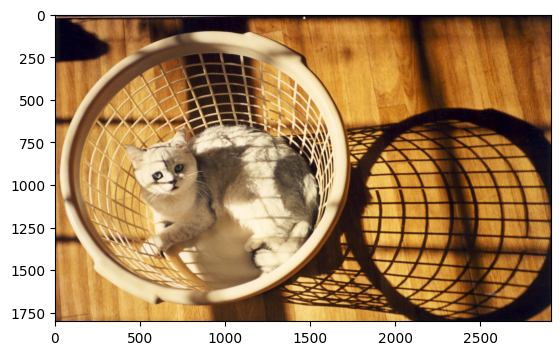

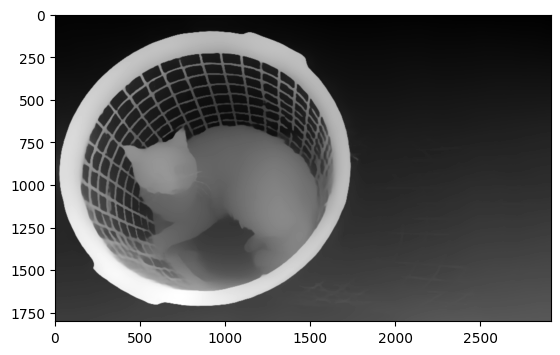

/root/miniconda3/envs/wsltorch/lib/python3.11/site-packages/torch/nn/functional.py:3809: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


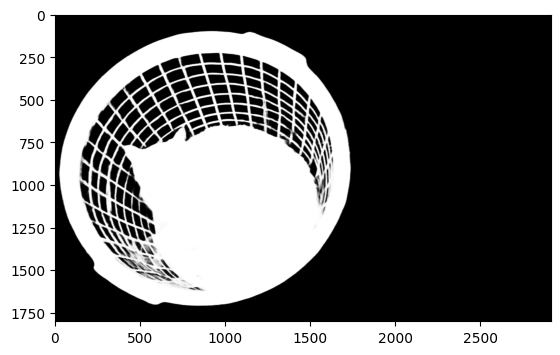

In [3]:
transforms = GOSNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
with torch.no_grad():
    img = cv2.imread(r"5#Artifact#1#Basket#3342299538_59c014a904_o.jpg")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    H,W = img.shape[:2]
    depth = DAMV2.infer_image(img)
    plt.imshow(cv2.resize(depth, (W,H)),cmap='gray')
    plt.show()
    img = cv2.resize(img, (1024,1024))
    depth = cv2.resize(depth, (1024,1024))
    img = torch.from_numpy(img).permute(2,0,1).float()/255
    img = transforms(img).unsqueeze(0)
    depth = torch.from_numpy(depth).unsqueeze(0).unsqueeze(0)/255
    DIS_map = model.inference(img.to(device),depth.to(device))[0][0][0].cpu()
    DIS_map = cv2.resize(np.array(DIS_map), (W,H))
    plt.imshow(DIS_map,cmap='gray')
    plt.show()